In [11]:
import segno
from segno import consts
import os
import random
import string
import io
from PIL import Image
from PIL import ImageOps
from utils import get_local_folder, get_random_background_path
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
background_folder = get_local_folder()
background_folder = os.path.dirname(background_folder)
background_folder = os.path.dirname(background_folder)
background_folder = os.path.dirname(background_folder)
background_folder = os.path.join(background_folder, "checker")
background_folder = os.path.join(background_folder, "src")
background_folder = os.path.join(background_folder, "backgrounds_org")
current_folder = get_local_folder()
N = 100



In [12]:
def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        diff = time2-time1
        print(f'{f.__name__} took {diff:.2f} s')
        print(f'{f.__name__} took {diff/N:.5f} s per iteration')
        return ret
    return wrap


In [13]:



def stress(SCALE, BORDER, iterations):
    original_image = Image.open(get_random_background_path(background_folder))
    flag = 'ENO'+''.join(random.choices(string.ascii_letters +
                                        string.digits + '\/=', k=48))
    qr = segno.make_qr(flag, error='L', boost_error=False, version=4)
    qr_size = qr.symbol_size(scale=SCALE, border=BORDER)
    original_image = ImageOps.contain(original_image, qr_size)
    processed_image = original_image.copy()
    box_image = Image.new('RGB', qr_size, (255, 255, 255))
    paste_x = (qr_size[0] - processed_image.size[0]) // 2
    paste_y = (qr_size[1] - processed_image.size[1]) // 2
    box_image.paste(processed_image, (paste_x, paste_y))
    box_image = box_image.convert('RGBA')

    keep_modules = (consts.TYPE_FINDER_PATTERN_DARK, consts.TYPE_FINDER_PATTERN_LIGHT, consts.TYPE_SEPARATOR,
                    consts.TYPE_ALIGNMENT_PATTERN_DARK, consts.TYPE_ALIGNMENT_PATTERN_LIGHT, consts.TYPE_TIMING_DARK,
                    consts.TYPE_TIMING_LIGHT)
    border_offset = BORDER * SCALE
    d = SCALE // 3
    holed_image = box_image.copy()
    for i, row in enumerate(qr.matrix_iter(scale=SCALE, border=BORDER, verbose=True)):
        for j, m in enumerate(row):
            # if qr_code keep_modules goes here make it transparent
            if m in keep_modules:
                holed_image.putpixel((i, j), (0, 0, 0, 0))
            # if in qr code and not in border
            if (i > border_offset and j > border_offset) and (i < qr_size[0] - border_offset and j < qr_size[1] - border_offset):
                if (((i // d) % 3 == 1) and ((j // d) % 3 == 1)):
                    holed_image.putpixel((i, j), (0, 0, 0, 0))
    save_path = os.path.join(current_folder, "holed_image.png")
    holed_image.save(save_path)

    def gen_qr(border, scale, img_path):
        final_image = Image.open(img_path)
        qr = segno.make_qr(flag, error='L', boost_error=False, version=4)
        qr_image = io.BytesIO()
        qr.save(qr_image, kind='png', border=border, scale=scale)
        qr_image = Image.open(qr_image)
        qr_image = qr_image.convert('RGBA')
        qr_image.paste(final_image, (0, 0), final_image)

    def loop_gen_qr():
        for _ in range(iterations):
            gen_qr(BORDER, SCALE, save_path)

    time_taken = time.time()
    loop_gen_qr()
    time_taken = time.time() - time_taken
    os.remove(save_path)
    return time_taken





In [14]:

# data = [stress(12, x, N) for x in range(100)]
data = [0 for _ in range(100)]
for i in tqdm(range(100), total=100):
    data[i] = stress(12, i, N)


100%|██████████| 100/100 [24:07<00:00, 14.47s/it]


In [15]:
import json
with open('stress_border.json', 'w') as f:
    json.dump(data, f)
    


In [16]:
import json
with open('stress_border.json', 'r') as f:
    data = json.load(f)

[Text(0.5, 0, 'Border'),
 Text(0, 0.5, 'Time (s)'),
 Text(0.5, 1.0, 'Time taken to generate 100 QR codes with different border size')]

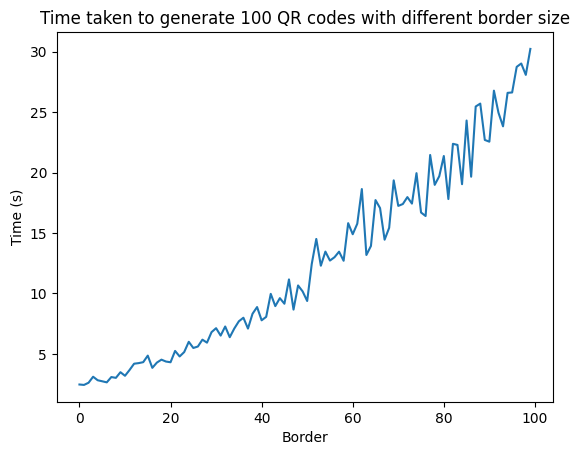

In [17]:
plot, ax = plt.subplots()
ax.plot(data)
ax.set(xlabel='Border', ylabel='Time (s)',
         title=f'Time taken to generate {N} QR codes with different border size')
